Let the FIR filter length be $ L+1$ samples, with $ L$ even, and suppose we'll initially design it to be centered about the time origin ("zero phase"). Then the frequency response is given on our frequency grid $ \omega_k$ by 

$$ 
\begin{align}
H(\omega_k) &= \sum_{n=-L/2}^{L/2} h_n e^{-j\omega_kn}, \; k=0,1,2,\ldots,N-1, \; N\gg L. \\
&= \sum_{n=-L/2}^{L/2} h_n (\cos(-j\omega_kn) + i\sin(-j\omega_kn)), \; k=0,1,2,\ldots,N-1, \; N\gg L. \\
&= h_0 + 2\sum_{n=1}^{L/2} h_n \cos (\omega_k n), \; k=0,1,2,\ldots, N-1,
\end{align}
$$

$$
H(\omega_0) = h_0 + h_1 2\cos(\omega_0) + h_2 2\cos(\omega_0 2) + h_3 2\cos(\omega_0 3) ...
$$

$$
\displaystyle \underbrace{\left[ \begin{array}{c} H(\omega_0) \\ H(\omega_1) \\ \vdots \\ H(\omega_{N-1}) \end{array} \right]}_{{\underline{d}}} = \underbrace{\left[ \begin{array}{ccccc} 1 & 2\cos(\omega_0) & \dots & 2\cos[\omega_0(L/2)] \\ 1 & 2\cos(\omega_1) & \dots & 2\cos[\omega_1(L/2)] \\ \vdots & \vdots & & \vdots \\ 1 & 2\cos(\omega_{N-1}) & \dots & 2\cos[\omega_{N-1}(L/2)] \end{array} \right]}_\mathbf{A} \underbrace{\left[ \begin{array}{c} h_0 \\ h_1 \\ \vdots \\ h_{L/2} \end{array} \right]}_{{\underline{h}}}
$$

In [1]:
from scipy import io
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

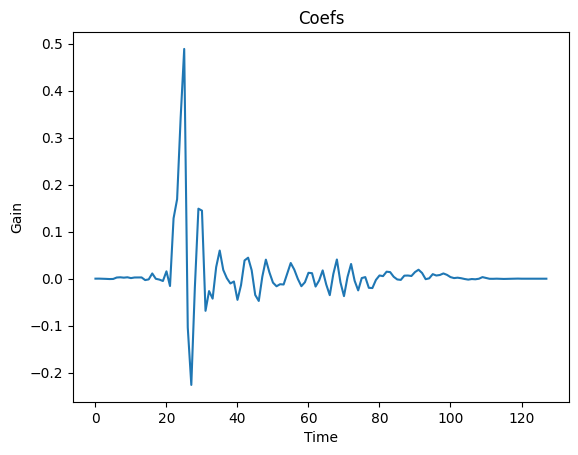

In [2]:
mat_data = io.loadmat('..//KU100_HRIR_FullKU100Coordinates.mat')
h = mat_data['hrir_l'][0][0]
plt.plot(h)
plt.ylabel('Gain')
plt.xlabel('Time')
plt.title('Coefs')
plt.show()

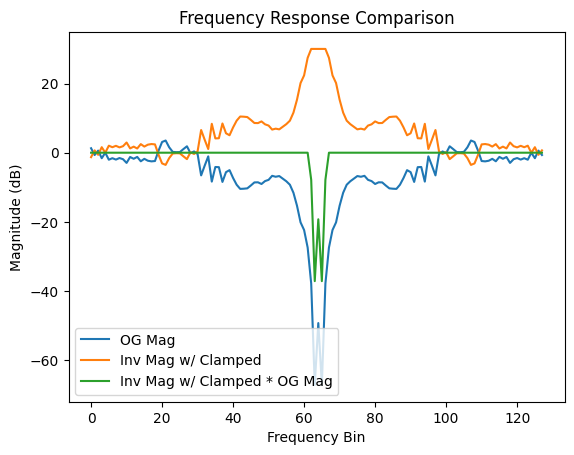

In [3]:
max_gain_db = 30  # Maximum gain allowed for the inverse filter in dB
min_gain_db = -30  # Minimum gain allowed for the inverse filter in dB

# Compute the FFT of the input data
H = np.fft.fft(h)

# Compute the inverse filter in the frequency domain
H_inv = 1 / H

# Separate the magnitude and phase of the inverse filter
H_inv_mag = np.abs(H_inv)  # Magnitude of the inverse filter
H_inv_phase = np.angle(H_inv)  # Phase of the inverse filter

# Clamp the magnitude of the inverse filter to the specified dB range
H_inv_mag = np.clip(H_inv_mag, 10**(min_gain_db / 20), 10**(max_gain_db / 20))
# Reconstruct the clamped inverse filter with the original phase
H_inv = H_inv_mag * np.exp(1j * H_inv_phase)

# Plot the magnitude responses
plt.plot(20*np.log10(np.abs(H)),       label='OG Mag')
plt.plot(20*np.log10(np.abs(H_inv)),   label='Inv Mag w/ Clamped')
plt.plot(20*np.log10(np.abs(H_inv*H)), label='Inv Mag w/ Clamped * OG Mag')
plt.legend()
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency Bin')
plt.title('Frequency Response Comparison')
plt.show()

In [4]:
def compute_approx_coefs(H_tgt):
    n = len(H_tgt)
    
    # Construct the matrix A for the least-squares computation
    row = np.arange(n)
    col = np.arange(n)
    A = np.exp(2j * np.pi * np.outer(row, col) / n)
    
    # Apply the least-squares method to solve for X
    # A @ X = H_tgt
    X = np.linalg.lstsq(A, H_tgt, rcond=None)[0].real

    return X

In [5]:
h_inv_approx = compute_approx_coefs(H_inv)
H_inv_approx = np.fft.fft(h_inv_approx)

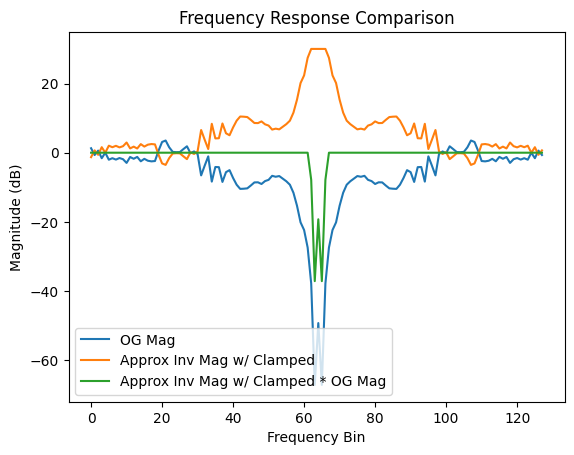

In [6]:
plt.plot(20*np.log10(np.abs(H)),              label='OG Mag')
plt.plot(20*np.log10(np.abs(H_inv_approx)),   label='Approx Inv Mag w/ Clamped')
plt.plot(20*np.log10(np.abs(H_inv_approx*H)), label='Approx Inv Mag w/ Clamped * OG Mag')
plt.legend()
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency Bin')
plt.title('Frequency Response Comparison')
plt.show()

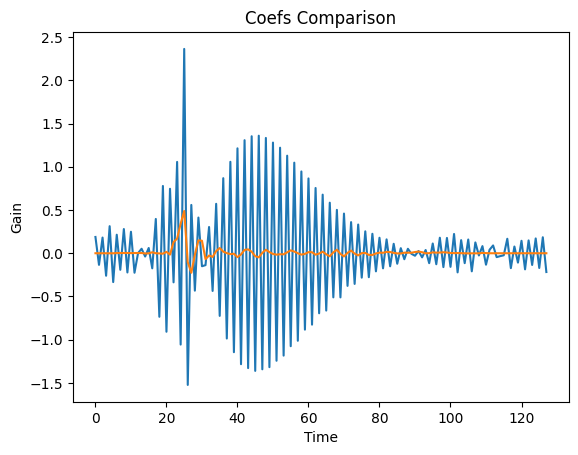

In [7]:
plt.plot(h_inv_approx)
plt.plot(h)
plt.ylabel('Gain')
plt.xlabel('Time')
plt.title('Coefs Comparison')
plt.show()